2025-12-08 17:54:08.222528: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 17:54:08.222915: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 17:54:08.282931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 17:54:09.722319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Loading and preparing data...
Running MSTL decomposition...
✓ MSTL decomposition done.
Defining common train/test split...
Train length: 5833, Test length: 649
--------------------------------------------------------------------------------
STARTING CUSTOM MODEL PIPELINE
[Main] Processing component: Trend (Polynomial Regression, Degree 2)
  ✓ Trend complete.
[Main] Processing component: Seasonal_143 (0.5*LSTM + 0.5*Naive)
  [LSTM] Processing component: Seasonal_143 (using 'simple' config)


E0000 00:00:1765196692.856008   18781 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765196692.862837   18781 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


  [Naive] Processing component: seasonal_143 (Period: 143)
  ✓ Seasonal_143 complete.
[Main] Processing component: Seasonal_687 (0.5*LSTM + 0.5*Naive)
  [LSTM] Processing component: Seasonal_687 (using 'default' config)
  [Naive] Processing component: seasonal_687 (Period: 687)
  ✓ Seasonal_687 complete.
[Main] Processing component: Seasonal_3200 (Standard LSTM)
  [LSTM] Processing component: Seasonal_3200 (using 'complex' config)
  ✓ Seasonal_3200 complete.
[Main] Processing component: Residual (Standard LSTM)
  [LSTM] Processing component: Residual (using 'residual' config)
  ✓ Residual complete.
--------------------------------------------------------------------------------
All components forecasted.
Recombining and evaluating...
                 FINAL CUSTOM HYBRID MODEL METRICS
  RMSE: 10.5378
  MAE:  7.9016
  MAPE: 2.89%
  (Metrics calculated on 649 non-NaN data points)
Generating final forecast plot...
✓ Comparison plot saved to 'custom_hybrid_plot_v2.1.png'
DONE.


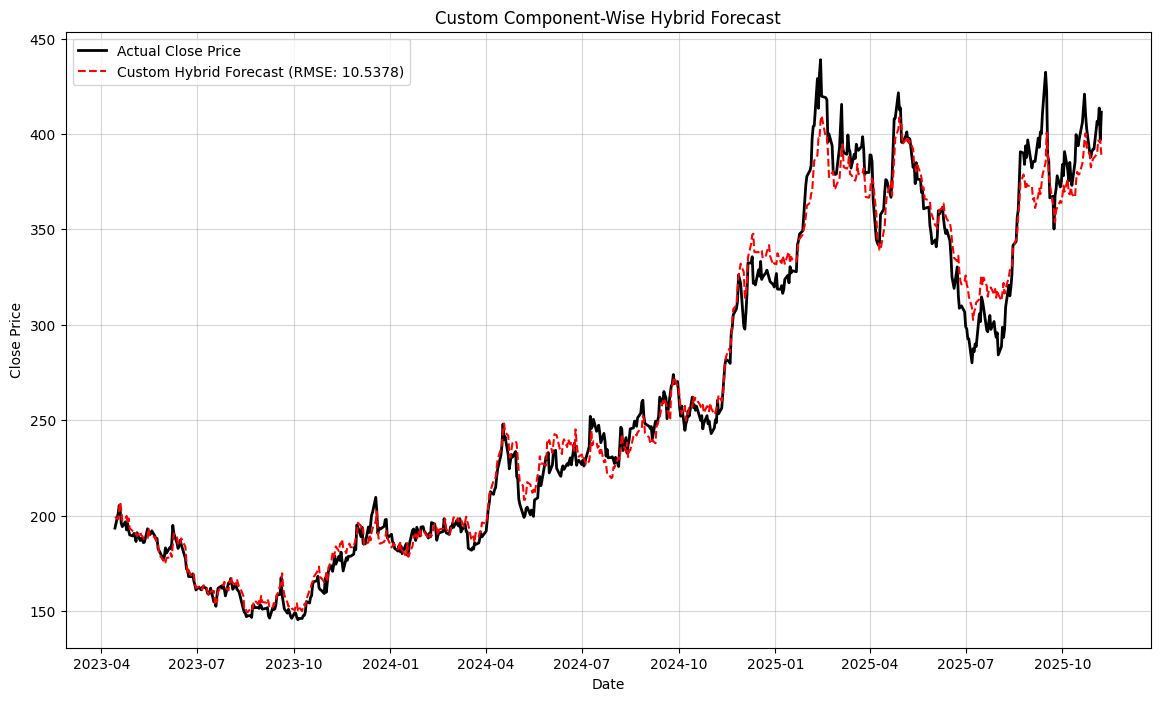

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
import warnings

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)

# --- Configs ---
DATA_PATH = 'full_stock_data.csv'
PERIODS = [143, 687, 3200]
TRAIN_RATIO = 0.90
TIME_STEP = 60
EPOCHS = 30
BATCH_SIZE = 32

# --- 1. Load Data ---
print("Loading and preparing data...")
try:
    df = pd.read_csv(DATA_PATH, parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{DATA_PATH}'.")
    raise SystemExit(f"Error: File not found at {DATA_PATH}.")

df = df.sort_index()
df = df.dropna(subset=['Close'])
y = df['Close']

# --- 2. MSTL Decomposition ---
print("Running MSTL decomposition...")
stl = MSTL(y, periods=PERIODS, iterate=2).fit()

components = {
    'Trend': stl.trend,
    'Seasonal_143': stl.seasonal['seasonal_143'],
    'Seasonal_687': stl.seasonal['seasonal_687'],
    'Seasonal_3200': stl.seasonal['seasonal_3200'],
}
# Find common index where all components are non-NaN
common_index = stl.trend.dropna().index
for k in components:
    components[k] = components[k].loc[common_index].dropna()
resid_series = stl.resid.loc[common_index].dropna()

# Re-align index after dropping all NaNs
common_index = resid_series.index
for k in components:
    components[k] = components[k].loc[common_index]
y_aligned = y.loc[common_index]

print("✓ MSTL decomposition done.")

# --- 3. Train/Test Split ---
print("Defining common train/test split...")
train_len = int(len(common_index) * TRAIN_RATIO)
train_index = common_index[:train_len]
test_index = common_index[train_len:]
forecast_horizon = len(test_index)
actual_close_test = y_aligned.loc[test_index]

print(f"Train length: {len(train_index)}, Test length: {len(test_index)}")
print("-" * 80)

# --- 4. Model Definitions ---

def get_model_architecture(key, time_step):
    """Returns a compiled Keras model based on a config key."""
    if key == 'simple':
        # Simple model for high-frequency
        model = keras.models.Sequential([
            keras.layers.LSTM(50, input_shape=(time_step, 1)),
            keras.layers.Dense(25, activation="relu"),
            keras.layers.Dense(1)
        ])
    elif key == 'complex':
        # Deeper model for long-term
        model = keras.models.Sequential([
            keras.layers.LSTM(128, return_sequences=True, input_shape=(time_step, 1)),
            keras.layers.LSTM(128, return_sequences=False),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1)
        ])
    else: # 'default' or 'residual'
        # Robust default
        model = keras.models.Sequential([
            keras.layers.LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
            keras.layers.LSTM(32, return_sequences=False),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1)
        ])
    
    model.compile(optimizer="adam", loss="mae")
    return model

def train_and_forecast_lstm(component_series, component_name, train_index, test_index, model_config_key='default'):
    """Trains an LSTM on a component, fitting the scaler on train data only."""
    print(f"  [LSTM] Processing component: {component_name} (using '{model_config_key}' config)")

    scaler = StandardScaler()
    
    # Fit scaler on train data only to prevent leakage
    train_data = component_series.loc[train_index].values.reshape(-1, 1)
    if len(train_data) > 1:
        scaler.fit(train_data)
    else:
        print(f"    WARNING: Not enough training data for {component_name} to fit scaler. Skipping.")
        return pd.Series(np.nan, index=test_index)

    # Transform all data
    scaled_data = scaler.transform(component_series.values.reshape(-1, 1))

    train_data_len = len(train_index)
    training_data_scaled = scaled_data[:train_data_len]
    # Need last window of train data to start test predictions
    test_prep_scaled = scaled_data[train_data_len - TIME_STEP:]
    
    X_train, y_train = [], []
    for i in range(TIME_STEP, len(training_data_scaled)):
        X_train.append(training_data_scaled[i-TIME_STEP:i, 0])
        y_train.append(training_data_scaled[i, 0])

    if len(X_train) == 0:
        print(f"    ERROR: Not enough data for {component_name} with TIME_STEP={TIME_STEP}. Skipping LSTM.")
        return pd.Series(np.nan, index=test_index)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    model = get_model_architecture(model_config_key, TIME_STEP)
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    
    X_test = []
    for i in range(TIME_STEP, len(test_prep_scaled)):
        X_test.append(test_prep_scaled[i-TIME_STEP:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions_scaled).flatten()
    
    # Align predictions to the test index
    final_preds = np.nan * np.ones(len(test_index))
    pred_len = min(len(predictions), len(test_index))
    final_preds[:pred_len] = predictions[:pred_len]

    return pd.Series(final_preds, index=test_index)


def forecast_seasonal_naive(component_series, period, train_index, test_index):
    """Forecasts by repeating the last known seasonal cycle."""
    print(f"  [Naive] Processing component: {component_series.name} (Period: {period})")
    train_series = component_series.loc[train_index]
    forecast_horizon = len(test_index)

    # Get last cycle and repeat it for the forecast horizon
    last_cycle = train_series.iloc[-period:]
    n_repeats = (forecast_horizon // period) + 1
    naive_forecast_vals = np.tile(last_cycle.values, n_repeats)[:forecast_horizon]

    return pd.Series(naive_forecast_vals, index=test_index)

# --- 5. Run Pipeline ---
print("STARTING CUSTOM MODEL PIPELINE")
all_forecasts = {}

# Trend: Polynomial Regression (Degree 2) to fit the curve
print("[Main] Processing component: Trend (Polynomial Regression, Degree 2)")
trend_train_series = components['Trend'].loc[train_index]
X_train_lr = np.arange(len(train_index)).reshape(-1, 1)
y_train_lr = trend_train_series.values

degree = 2
poly_reg = make_pipeline(PolynomialFeatures(degree, include_bias=False), LinearRegression())
poly_reg.fit(X_train_lr, y_train_lr)

X_test_lr = np.arange(len(train_index), len(train_index) + forecast_horizon).reshape(-1, 1)
trend_forecast = poly_reg.predict(X_test_lr)
all_forecasts['Trend'] = pd.Series(trend_forecast, index=test_index)
print("  ✓ Trend complete.")

# Seasonal_143: Ensemble (LSTM + Naive)
print("[Main] Processing component: Seasonal_143 (0.5*LSTM + 0.5*Naive)")
lstm_s143_forecast = train_and_forecast_lstm(
    components['Seasonal_143'], 'Seasonal_143', train_index, test_index,
    model_config_key='simple'
)
naive_s143_forecast = forecast_seasonal_naive(
    components['Seasonal_143'], 143, train_index, test_index
)
all_forecasts['Seasonal_143'] = 0.5 * lstm_s143_forecast + 0.5 * naive_s143_forecast
print("  ✓ Seasonal_143 complete.")

# Seasonal_687: Ensemble (LSTM + Naive)
print("[Main] Processing component: Seasonal_687 (0.5*LSTM + 0.5*Naive)")
lstm_s687_forecast = train_and_forecast_lstm(
    components['Seasonal_687'], 'Seasonal_687', train_index, test_index,
    model_config_key='default'
)
naive_s687_forecast = forecast_seasonal_naive(
    components['Seasonal_687'], 687, train_index, test_index
)
all_forecasts['Seasonal_687'] = 0.5 * lstm_s687_forecast + 0.5 * naive_s687_forecast
print("  ✓ Seasonal_687 complete.")

# Seasonal_3200: LSTM only
print("[Main] Processing component: Seasonal_3200 (Standard LSTM)")
all_forecasts['Seasonal_3200'] = train_and_forecast_lstm(
    components['Seasonal_3200'], 'Seasonal_3200', train_index, test_index,
    model_config_key='complex'
)
print("  ✓ Seasonal_3200 complete.")

# Residual: LSTM
print("[Main] Processing component: Residual (Standard LSTM)")
all_forecasts['Residual'] = train_and_forecast_lstm(
    resid_series, 'Residual', train_index, test_index,
    model_config_key='residual'
)
print("  ✓ Residual complete.")

print("-" * 80)
print("All components forecasted.")

# --- 6. Evaluate ---
print("Recombining and evaluating...")
forecast_df = pd.DataFrame(all_forecasts)

# Sum all component forecasts
final_prediction_pd = forecast_df.sum(axis=1)

# Align actuals and forecast; drop NaNs for fair metric calculation
error_df = pd.DataFrame({
    'actual': actual_close_test,
    'forecast': final_prediction_pd
}).dropna() 

if error_df.empty:
    print("=" * 80)
    print("                 FINAL CUSTOM HYBRID MODEL METRICS")
    print("=" * 80)
    print("ERROR: Cannot calculate metrics. No overlapping data between actuals and forecasts after dropping NaNs.")
    print("This can happen if a model (e.g., LSTM) failed to produce a forecast.")
    print("=" * 80)
else:
    rmse_final = np.sqrt(mean_squared_error(error_df['actual'], error_df['forecast']))
    mae_final = mean_absolute_error(error_df['actual'], error_df['forecast'])
    safe_actual = error_df['actual'].replace(0, 1e-6) # Avoid division by zero in MAPE
    mape_final = np.mean(np.abs((error_df['actual'] - error_df['forecast']) / safe_actual)) * 100

    print("=" * 80)
    print("                 FINAL CUSTOM HYBRID MODEL METRICS")
    print("=" * 80)
    print(f"  RMSE: {rmse_final:.4f}")
    print(f"  MAE:  {mae_final:.4f}")
    print(f"  MAPE: {mape_final:.2f}%")
    print(f"  (Metrics calculated on {len(error_df)} non-NaN data points)")
    print("=" * 80)

# --- 7. Plot ---
print("Generating final forecast plot...")
plt.figure(figsize=(14, 8))
plt.plot(actual_close_test, label="Actual Close Price", color='black', linewidth=2)

plt.plot(final_prediction_pd.dropna(),
         label=f"Custom Hybrid Forecast (RMSE: {rmse_final:.4f})",
         color='red', linestyle='--')

plt.title("Custom Component-Wise Hybrid Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)

plot_filename = 'custom_hybrid_plot_v2.1.png'
plt.savefig(plot_filename)
print(f"✓ Comparison plot saved to '{plot_filename}'")
print("DONE.")